In [69]:
%matplotlib inline

import autograd.numpy as np
from autograd.extend import primitive, defvjp
from autograd.numpy.numpy_vjps import unbroadcast_f
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from torch import normal

sns.set_style("white")
sns.set_context("talk")

np.random.seed(42)

## Data

In [2]:
data = np.random.randn(20)

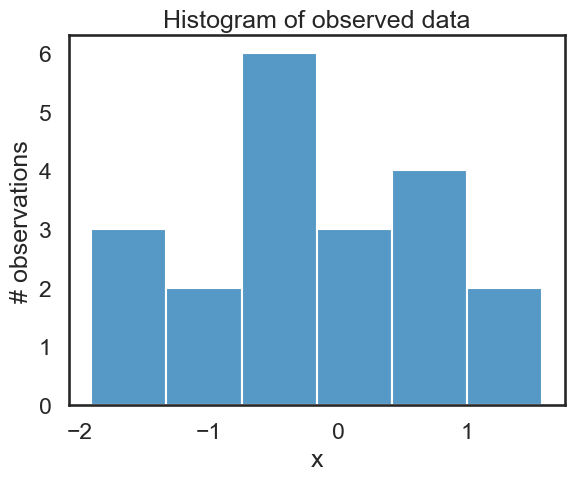

In [3]:
ax = plt.subplot()
sns.histplot(data, ax=ax)

_ = ax.set(title="Histogram of observed data", xlabel="x", ylabel="# observations")

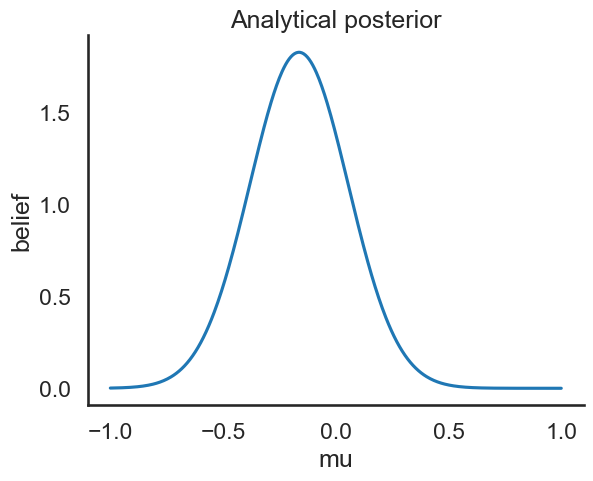

In [4]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. /sigma_0**2 + n/sigma**2) ** -1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, posterior_analytical)
ax.set(xlabel="mu", ylabel="belief", title="Analytical posterior")
sns.despine()

## MCMC

In [5]:
def sampler(
        data,
        samples = 4,
        mu_init = 0.5,
        proposal_width = 0.5,
        plot = False,
        mu_prior_mu = 0,
        mu_prior_sd = 1.
        ):
    mu_current = mu_init
    posterior = [mu_current]

    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelohood by multiplying probabilities of each datapoint
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        # Compute prior probability of current and proposed mu
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept proposal?
        p_accept = p_proposal / p_current

        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept

        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)

        if accept:
            # Update position
            mu_current = mu_proposal

        posterior.append(mu_current)
        
    return np.array(posterior)

def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy

    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle("Iteration %s" % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = "g" if accepted else "r"

    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker = "o", color = "b")
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker = "o", color = color)
    ax1.annotate("", xy = (mu_proposal, 0.2), xytext = (mu_current, 0.2), arrowprops = dict(arrowstyle = "->", lw = 2.))
    ax1.set(ylabel = "Probability Density", title = "current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f" % (mu_current, prior_current, mu_proposal, prior_proposal))

    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc = mu_proposal, scale = 1).pdf(x)
    sns.histplot(data, ax=ax2, stat = "density")
    ax2.plot(x, y, color = color)
    ax2.axvline(mu_current, color = "b", linestyle = "--", label = "mu_current")
    ax2.axvline(mu_proposal, color = color, linestyle = "-", label = "mu_proposal")
    ax2.annotate("", xy = (mu_proposal, 0.2), xytext = (mu_current, 0.2), arrowprops = dict(arrowstyle = "->", lw = 2.))
    ax2.set(title = "likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f" % (mu_current,  likelihood_current, mu_proposal, likelihood_proposal))

    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker = "o", color = "b")
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker = "o", color = color)
    ax3.annotate("", xy = (mu_proposal, 0.2), xytext = (mu_current, 0.2), arrowprops = dict(arrowstyle = "->", lw = 2.))
    ax3.set(title = "posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f" % (mu_current, posterior_current, mu_proposal, posterior_proposal))

    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    
    ax4.plot(trace)
    ax4.set(xlabel = "iteration", ylabel = "mu", title = "trace")
    plt.tight_layout()

array([-1.        , -0.26717562, -0.38006377, -0.38006377, -0.32460247,
       -0.32460247, -0.47044935, -0.47719796, -0.47719796])

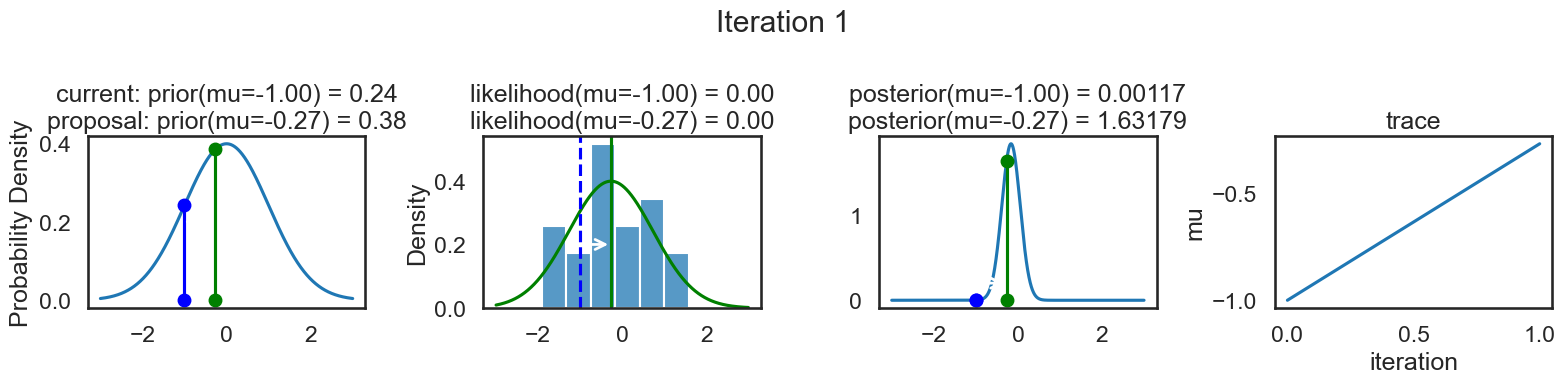

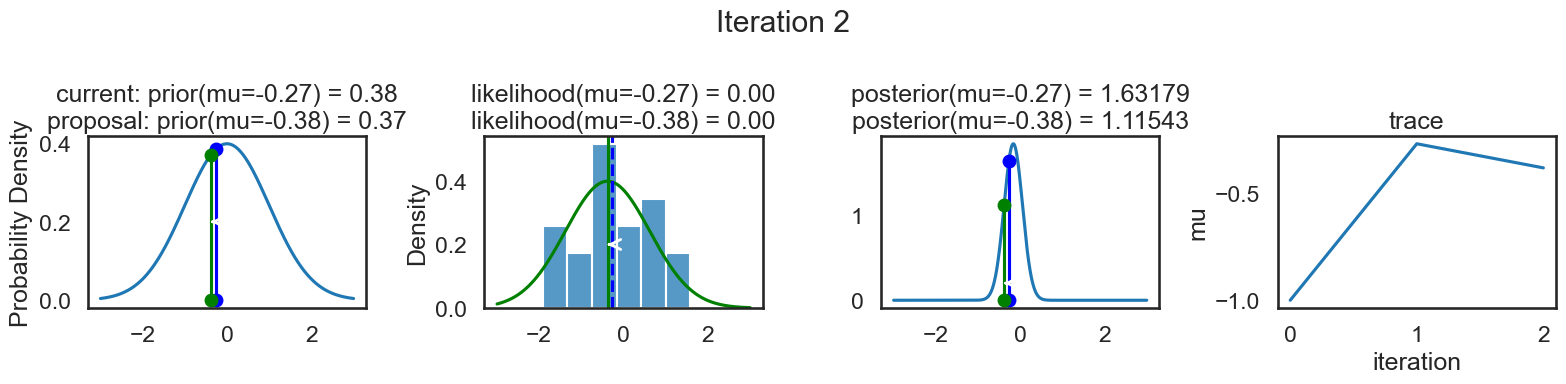

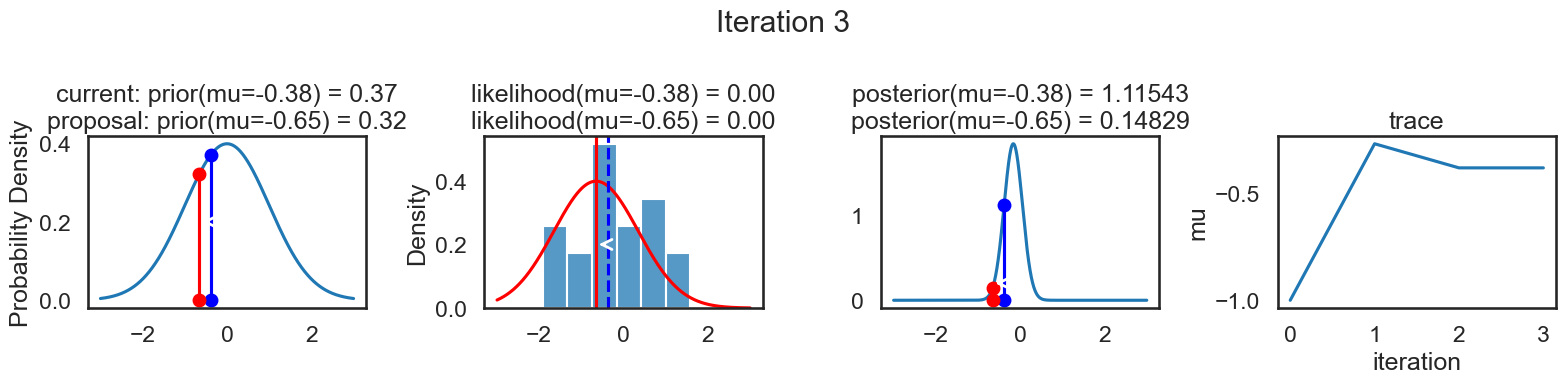

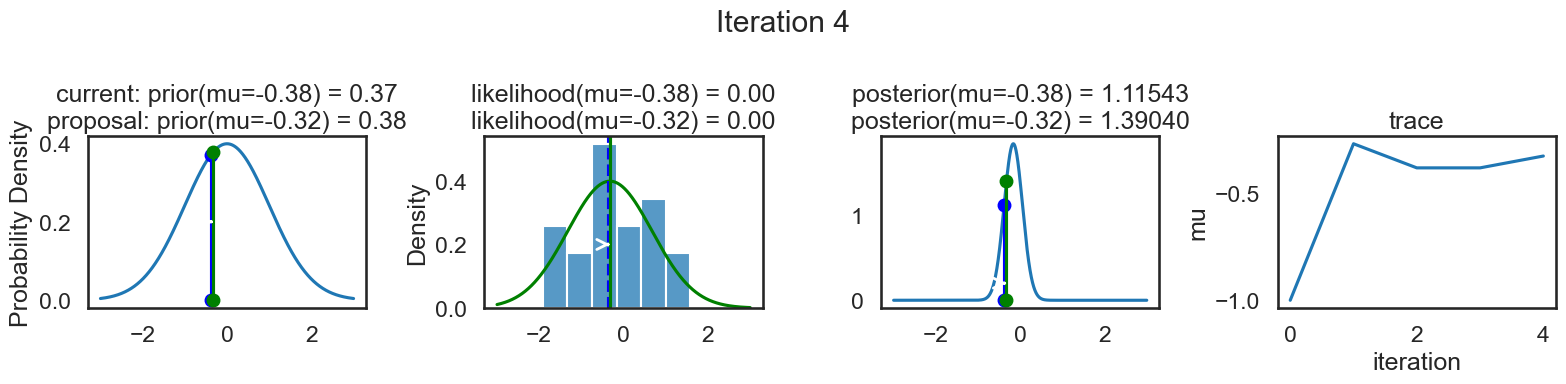

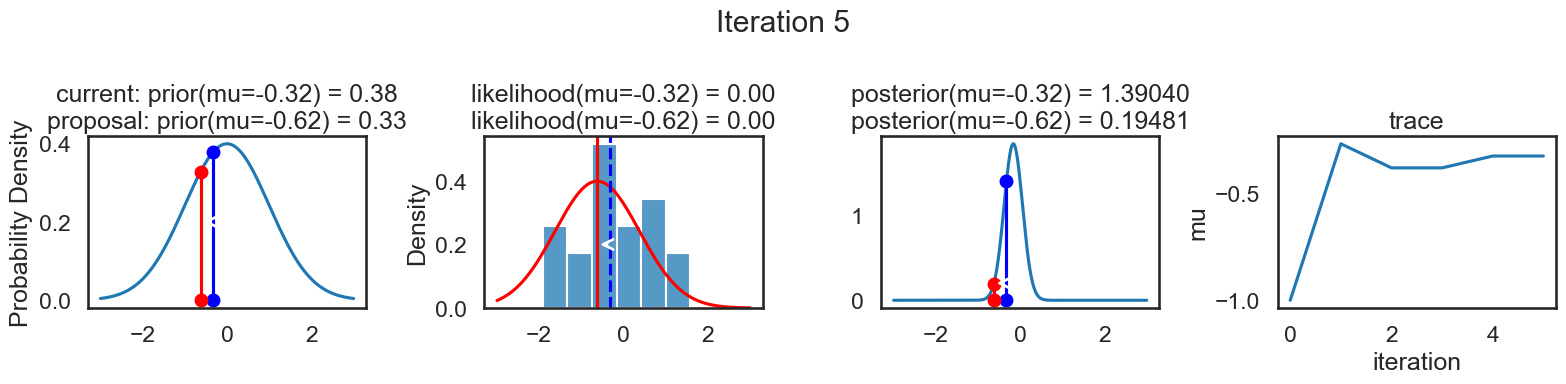

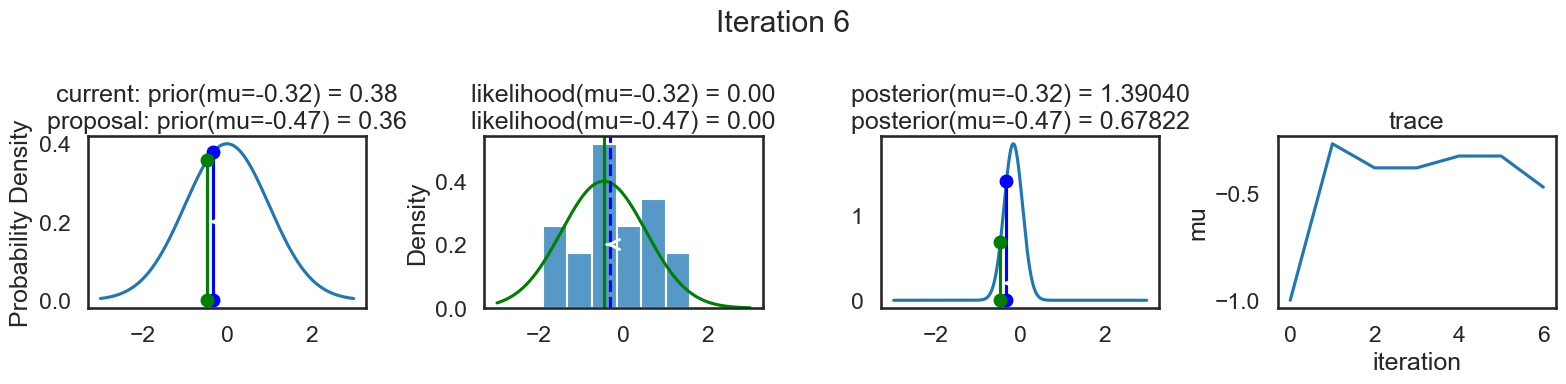

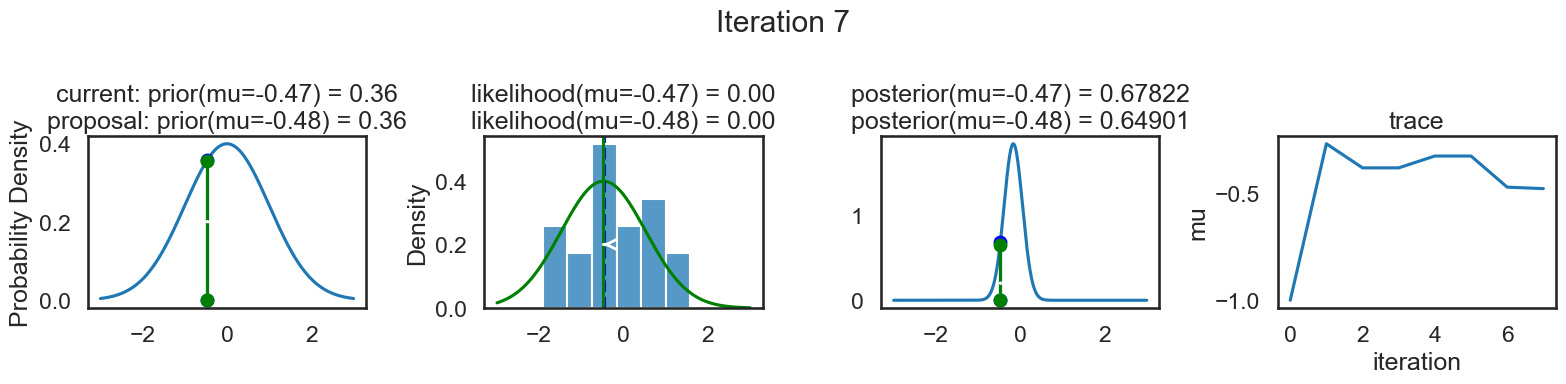

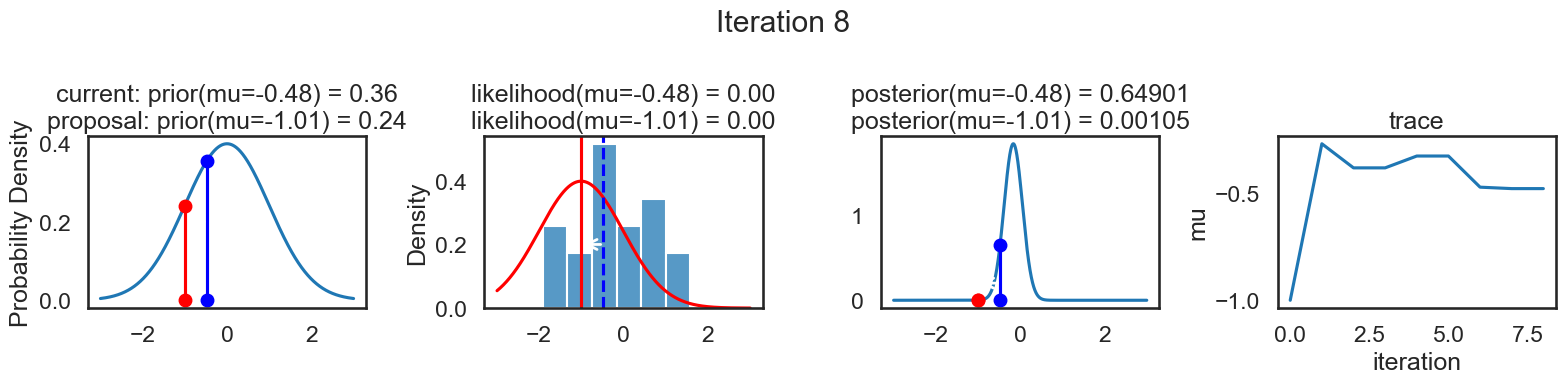

In [6]:
sampler(data, samples = 8, mu_init = -1, plot = True)

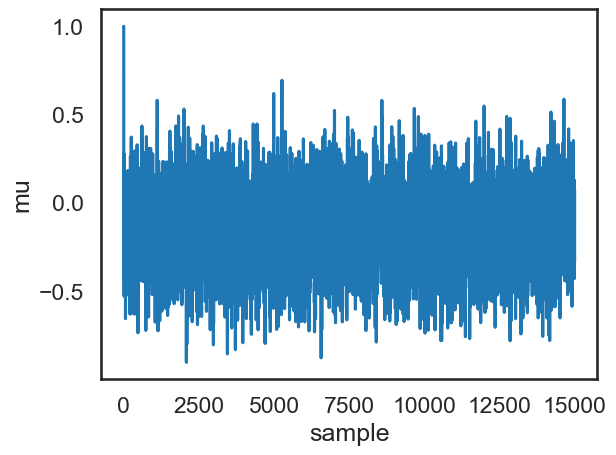

In [7]:
posterior = sampler(data, samples = 15_000, mu_init = 1., plot = False)

fig, ax = plt.subplots()

ax.plot(posterior)
_ = ax.set(xlabel = "sample", ylabel = "mu")

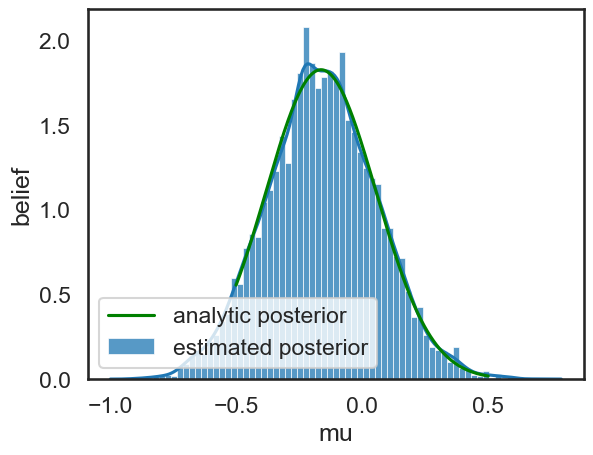

In [8]:
ax = plt.subplot()

sns.histplot(posterior[500:], ax = ax, label = "estimated posterior", stat = "density")
sns.kdeplot(posterior[500:], ax = ax)
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, "g", label = "analytic posterior")
_ = ax.set(xlabel = "mu", ylabel = "belief")
ax.legend()

## Hamiltonian

### Scipy and autograd

In [9]:
from autograd import grad
import autograd.numpy as np
import scipy.stats as st


def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    # autograd magic
    dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

In [35]:
def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    print(step_size, dVdq(q))

    p -= step_size * dVdq(q) / 2  # half step

    print(p)
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p

In [36]:
X = np.random.randn(1)
N = 1000
negative_log_prob = norm(0, 1).logpdf

hamiltonian_monte_carlo(10, negative_log_prob, X[0], path_len=1, step_size=0.5)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [53]:
test = norm(0, 1).logpdf

(test(1.20000000001) - test(1.2))/0.00000000001

-1.1999956583963467

In [71]:
negative_log_prob = lambda x: -norm.logpdf(x, 0, 1)
negative_log_prob = primitive(negative_log_prob)

defvjp(negative_log_prob,
       lambda ans, x, loc=0.0, scale=1.0:
       unbroadcast_f(x, lambda g: -g * ans * (x - loc) / scale**2),
       lambda ans, x, loc=0.0, scale=1.0:
       unbroadcast_f(loc, lambda g: g * ans * (x - loc) / scale**2),
       lambda ans, x, loc=0.0, scale=1.0:
       unbroadcast_f(scale, lambda g: g * ans * (((x - loc)/scale)**2 - 1.0)/scale))

samples = hamiltonian_monte_carlo(10, negative_log_prob, X[0], path_len=1, step_size=0.5)

0.5 -0.5392696958289933
0.6315315769684811
0.5 -0.5392696958289933
-0.003446877213936328
0.5 -0.7254529171067261
0.8290517673773741
0.5 -0.7254529171067261
1.704393085684707
0.5 -0.7254529171067261
-0.052790145446654446
0.5 -0.9226052362674115
-0.0034856478823276638
0.5 -1.3925767267893865
1.927356997204738
0.5 -1.3925767267893865
1.1155789108502554
0.5 -1.3925767267893865
-0.12133020423760549
0.5 -1.9088389221087905
1.0197697741131622


In [ ]:
negative_log_prob = lambda x: -norm(0, 1).logpdf(x)
negative_log_prob(1.2)

#samples = hamiltonian_monte_carlo(10, negative_log_prob, X[0], path_len=1, step_size=0.5)

### PyMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [post]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


array([[<Axes: title={'center': 'post'}>,
        <Axes: title={'center': 'post'}>]], dtype=object)

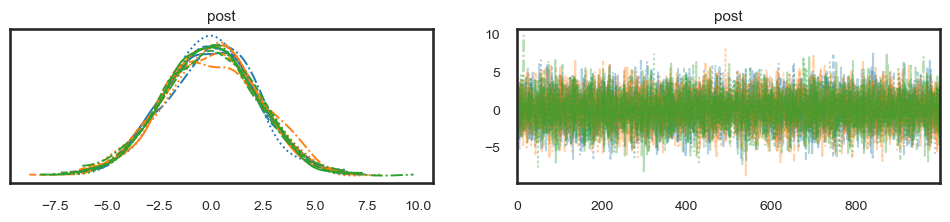

In [129]:
#  multivariate normal model in pymc3
import pymc as pm
import arviz as az

with pm.Model() as model:
    # multivariate normal
    post = pm.MvNormal("post", mu = np.zeros(3), cov = np.eye(3)*5, shape = 3)
    trace = pm.sample(1000)

az.plot_trace(trace)

In [133]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [131]:
typical_set = np.concatenate([np.ravel(low_bound).reshape(-1,1), np.ravel(high_bound).reshape(-1, 1)], axis = 1)

array([[-6.8126683 ,  7.43170921],
       [-8.77281113,  8.1930921 ],
       [-8.21162732,  9.77706165]])

In [132]:
def generate_array(start, end, n):
    # Generate an array with values from start to end with decreasing intervals
    if end == np.inf:
        arr = np.cumsum(np.exp(np.linspace(0, 5, n)))
        # No need to normalize to end value, since it is infinite
        arr = (arr - arr[0])
    else:
        arr = np.cumsum(np.exp(-np.linspace(0, 5, n)))
        # Normalize the array to ensure it ranges from start to end
        arr = (arr - arr[0]) / (arr[-1] - arr[0]) * (end - start) + start
    
    return arr

def pdf_space(start, end, n = 10000):
    mean = np.array([start, end]).mean()
    arr2 = generate_array(mean, end, int(n/2))
    arr1 = generate_array(-mean, -start, int(n/2)) * -1
    return np.concatenate([arr1[::-1], arr2])